# Vehicle Detection And Tracking

## Import libraries

In [1]:
from moviepy.editor import VideoFileClip

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import cv2

import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np

import os

import time

In [63]:
# Debug variable to print output
DBG = False#True

## Load car and non-car images

In [14]:
dataset_base_dir = 'dataset/'
car_dataset = 'vehicles/'
noncar_dataset = 'non-vehicles/'

cars = []
noncars = []

# Get different folders inside the car dataset
img_types = os.listdir(dataset_base_dir + car_dataset)

for folder in img_types:
    cars.extend(glob.glob(dataset_base_dir + car_dataset + folder + '/*'))

# Get different folders inside the noncar dataset
img_types = os.listdir(dataset_base_dir + noncar_dataset)

for folder in img_types:
    noncars.extend(glob.glob(dataset_base_dir + noncar_dataset + folder + '/*'))

    
print("Total number of Cars in dataset: {}".format(len(cars)))
print("Total number of Non-Cars in dataset: {}".format(len(noncars)))

Total number of Cars in dataset: 8792
Total number of Non-Cars in dataset: 8968


## Get Features from Image (HOG, Color Histogram and Bin Spatial)

In [15]:
###########################################
# Color Histogram features
###########################################

# Assuming input channel is cv2 order (BGR)
# Also check cv2 reads in png images in range (0, 256)
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features


In [16]:

###########################################
# Bin Spatial features
###########################################

# Remember to give src image in BGR format
def bin_spatial(img, size=(32, 32)):
    
    # Resize the image to specified size
    img_resized = cv2.resize(img, size)
    
    # Get features from image
    bin_features = img_resized.ravel()
    
    return  bin_features


In [17]:
###########################################
# HOG (Histogram of Oriented gradients) features
###########################################

def get_hog_features(one_channel_img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vect=True):
    
    # IF visualation is true, return the HOG image too
    if vis == True:
        hog_features, hog_img = hog(one_channel_img,
                                orientations=orient,
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block),
                                visualise=vis,
                                feature_vector=feature_vect)
        
        return hog_features, hog_img
    else:
        hog_features = hog(one_channel_img,
                                orientations=orient,
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block),
                                visualise=vis,
                                feature_vector=feature_vect)
        return hog_features
    


In [71]:
###########################################
# Get combined features (Bin Spatial, Histogram and HOG)
########################################### 

def single_img_feature(img,
                       cspace='RGB', 
                       spatial_size=(32, 32), 
                       hist_bins=32, hist_range=(0, 256),
                       orient=9, pix_per_cell=8, cell_per_block=2,
                       hog_channel=0,
                       spatial_feat=True, hist_feat=True, hog_feat=True):
    
    feature_image = np.copy(img) 
    single_img_feature = []
    
    if DBG == True:
        print('In single feature image')
        print(feature_image.shape)
    
    # apply color conversion based on color space
    if cspace == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif cspace == 'RGB':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif cspace == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)  
    
    #if DBG == True:
    #    plt.imshow(feature_image, cmap='gray')
    
    if spatial_feat == True:
        bin_spatial_features = bin_spatial(feature_image, size=spatial_size)    
        single_img_feature.append(bin_spatial_features)
        
        if DBG == True:
            print("Bin spatial features len: {}".format(len(bin_spatial_features)))
        
        
    if hist_feat == True:
        rhist, ghist, bhist, bin_centers, color_hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        single_img_feature.append(color_hist_features)
        
        if DBG == True:
            print("Color histogram features len: {}".format(len(color_hist_features)))
        
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_feature = []
        
            for channel in range(feature_image.shape[2]):
                single_hog_channel_feat = get_hog_features(feature_image[:,:,channel],
                                                           orient=orient, 
                                                           pix_per_cell=pix_per_cell, 
                                                           cell_per_block=cell_per_block, 
                                                           vis=False, 
                                                           feature_vect=True)
                # Append one channel hog feature to a list
                hog_feature.append(single_hog_channel_feat)
            
            #Combine all 3 channel hog features as one
            hog_feature = np.ravel(hog_feature)
        else:
            hog_feature = get_hog_features(feature_image[:,:,hog_channel],
                                           orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, 
                                           vis=False, 
                                           feature_vect=True)
            
            #feat_hog, hog_image = get_hog_features(feature_image[:,:,hog_channel],
            #                               orient=orient, 
            #                               pix_per_cell=pix_per_cell, 
            #                               cell_per_block=cell_per_block, 
            #                               vis=True, 
            #                               feature_vect=False)
            #
            #plt.imshow(hog_image, cmap='hot')
            
        # Add hog feature(s) to image features
        single_img_feature.append(hog_feature)

        if DBG == True:
            print("HOG features len: {}".format(len(hog_feature)))
            
    
            
    if DBG == True:
        print('Single image feature len: {}'.format(len(single_img_feature)))
    
    
    # Return concatenated features for a single image
    features_concat = np.concatenate(single_img_feature, axis=0)
    
    if DBG == True:
        print('Concatenated feature len: {}'.format(len(features_concat)))
    
    return features_concat

In [66]:
# Get features from a list of images
def extract_features(list_of_imgs, 
                     cspace='RGB', 
                     spatial_size=(32, 32), 
                     hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2,
                     hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Store all features for all images
    total_features = []
    
    for img_path in list_of_imgs:
        img = cv2.imread(img_path)
        
        single_img_features = single_img_feature(img,
                                                 cspace=cspace, 
                                                 spatial_size=spatial_size, 
                                                 hist_bins=hist_bins, 
                                                 hist_range=hist_range,
                                                 orient=orient, 
                                                 pix_per_cell=pix_per_cell, 
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, 
                                                 hist_feat=hist_feat, 
                                                 hog_feat=hog_feat)

        # Concatenate this image features (bin spatial, hist, hog) as one and append with other img feat list
        total_features.append(single_img_features)
        
    return total_features

## Get Sliding Window Bounding Box in an Image

In [67]:
def get_sliding_window_boxes(img, 
                   x_start_stop=[None, None], 
                   y_start_stop=[None, None],
                   xy_window_size=(64, 64),
                   xy_overlap_size=(0.5, 0.5)):
    
    # If x and/or y start/stop positions are not defined, set it to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Calculate the image span to be searched
    x_span = (x_start_stop[1] - x_start_stop[0])
    y_span = (y_start_stop[1] - y_start_stop[0])
    
    # Calculate the number of pixels per window
    nx_pix_per_step = np.int(xy_window_size[0] * (1 - xy_overlap_size[0]))
    ny_pix_per_step = np.int(xy_window_size[1] * (1 - xy_overlap_size[1]))
    
    #Calculate the number of windows in x/y direction
    nx_buffer = np.int(xy_window_size[0] * xy_overlap_size[0])
    ny_buffer = np.int(xy_window_size[1] * xy_overlap_size[1])
    
    nx_windows = np.int( (x_span - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int( (y_span - ny_buffer) / ny_pix_per_step)
    
    
    # Store window size in a list
    window_list = []
    
    # Go through each window in x and y to calculate window position
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            # Get window start position
            start_x = ( (xs * nx_pix_per_step) + x_start_stop[0])
            start_y = ( (ys * ny_pix_per_step) + y_start_stop[0])
            
            # Get the window end position
            end_x = start_x + xy_window_size[0]
            end_y = start_y + xy_window_size[1]
            
            # Append window position to list
            window_list.append( ( (start_x, start_y), (end_x, end_y) ) )
    
    # Return the list of windows
    return window_list

## Draw bounding box on image

In [68]:
def draw_boxes(img, bounding_boxes, color=(0, 0, 255), thick=6):
    
    img_copy = np.copy(img)
    
    # Go through all the bounding boxes and draw a rectangle
    for box in bounding_boxes:
        cv2.rectangle(img_copy, box[0], box[1], color, thick)

    # Return image with boxes drawn
    return img_copy

## Search and Classify Cars in Sliding Window Image

In [69]:
def search_windows_and_classify(img,
                                window_list,
                                classifier,
                                scaler,
                                cspace='RGB', 
                                spatial_size=(32, 32), 
                                hist_bins=32, hist_range=(0, 256),
                                orient=9, pix_per_cell=8, cell_per_block=2,
                                hog_channel=0,
                                spatial_feat=True, hist_feat=True, hog_feat=True):
    
    #Store list of windows where car is detected
    detected_car_windows = []
    
    # Go through all windows and apply classifier to detect if car is detected.
    for window in window_list:
        
        #Extract the window size image from whole image and resize it to dataset image size
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #Extract features from this test image
        features = single_img_feature(test_img,
                                     cspace=cspace, 
                                     spatial_size=spatial_size, 
                                     hist_bins=hist_bins, 
                                     hist_range=hist_range,
                                     orient=orient, 
                                     pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block,
                                     hog_channel=hog_channel,
                                     spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, 
                                     hog_feat=hog_feat)
        

        #Scale and normalize the features
        scaled_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #Make a prediction about this window image
        predict = classifier.predict(scaled_features)
        
        #If predicted to be a car, save it to car list
        if predict == 1:
            detected_car_windows.append(window)
    
    
    # Return the list of windows in which car is detected
    return detected_car_windows
        

## Test feature extraction on images

In [23]:
car_index = np.random.randint(0, len(cars))
not_car_index = np.random.randint(0, len(noncars))

car_img = cv2.imread(cars[car_index])
#car_img = cv2.imread('dataset/vehicles/KITTI_extracted/437.png')
not_car_img = cv2.imread(noncars[not_car_index])


#Define features values
color_space = 'RGB'

# Bin spatial feature - size to reduce image to
spatial_size = (32, 32)

# Color Histogram feature - No of histogram bins
hist_bins = 16
# Color Histogram feature - Histogram color range
hist_range=(0, 256)

# HOG feature - orientations
orient = 9
# HOG feature - No of pixels per cell
pix_per_cell = 8
# HOG feature - No of cells per block
cell_per_block = 2
# HOG feature - Channel to extract hog feature
hog_channel = 0

#Spatial features on or off
spatial_feat = True
#Histogram features on or off
hist_feat = True 
#HOG features on or off
hog_feat = True

#Define Min and Max Y position to extract features in image
y_start_stop = [450, 710]


car_features = single_img_feature(car_img, cspace=color_space,  spatial_size=spatial_size, 
                       hist_bins=hist_bins, hist_range=hist_range,
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, hog_channel=hog_channel,
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


not_car_features = single_img_feature(not_car_img, cspace=color_space,  spatial_size=spatial_size, 
                       hist_bins=hist_bins, hist_range=hist_range,
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, hog_channel=hog_channel,
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print("Length of car features: {}".format(len(car_features)))
print("Length of non-car features: {}".format(len(not_car_features)))

Length of car features: 4884
Length of non-car features: 4884


In [24]:
# Test feature extraction on list of images
# cars = list of car images
# noncars = list of non-car images


#Define features values
color_space = 'RGB'

# Bin spatial feature - size to reduce image to
spatial_size = (32, 32)

# Color Histogram feature - No of histogram bins
hist_bins = 16
# Color Histogram feature - Histogram color range
hist_range=(0, 256)

# HOG feature - orientations
orient = 9
# HOG feature - No of pixels per cell
pix_per_cell = 8
# HOG feature - No of cells per block
cell_per_block = 2
# HOG feature - Channel to extract hog feature
hog_channel = 'ALL'

#Spatial features on or off
spatial_feat = True
#Histogram features on or off
hist_feat = True 
#HOG features on or off
hog_feat = True

#Define Min and Max Y position to extract features in image
y_start_stop = [450, 710]


t_start = time.time()

car_features = extract_features(cars, cspace=color_space,  spatial_size=spatial_size, 
                       hist_bins=hist_bins, hist_range=hist_range,
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, hog_channel=hog_channel,
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


not_car_features = extract_features(noncars, cspace=color_space,  spatial_size=spatial_size, 
                       hist_bins=hist_bins, hist_range=hist_range,
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, hog_channel=hog_channel,
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

t_end = time.time()

print('Total time to compute features: {} seconds'.format(t_end-t_start))
print("Length of car features: {}".format(len(car_features)))
print("Length of non-car features: {}".format(len(not_car_features)))


Total time to compute features: 142.2642138004303 seconds
Length of car features: 8792
Length of non-car features: 8968


In [25]:
#Apply scalar transform to features to normalize them

#Stack cars and noncars feature vectors to create one single feature for classification
X = np.vstack((car_features, not_car_features)).astype(np.float64)

#Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

#Apply the scaler to X
scaled_X = X_scaler.transform(X)


#Define the labels vector
y_labels = np.hstack( (np.ones(len(car_features)), np.zeros(len(not_car_features))) )


# Now Split the data into training and testing set
test_size = 0.2
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_labels, test_size=test_size, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 8412


In [54]:
print('Feature vector length:', len(X_scaler.scale_))
print('X vector:', X)
print('Scaled X vector:', scaled_X)

Feature vector length: 8412
X vector: [[  2.16000000e+02   2.20000000e+02   2.05000000e+02 ...,   6.68093172e-03
    7.20547717e-03   6.35653031e-02]
 [  5.10000000e+01   7.40000000e+01   5.90000000e+01 ...,   3.69930683e-03
    2.34983023e-03   5.02279594e-03]
 [  1.21000000e+02   1.16000000e+02   9.80000000e+01 ...,   4.59226456e-03
    0.00000000e+00   2.69407667e-03]
 ..., 
 [  1.54000000e+02   1.58000000e+02   1.44000000e+02 ...,   4.12816109e-02
    5.55479384e-03   0.00000000e+00]
 [  1.11000000e+02   1.08000000e+02   9.00000000e+01 ...,   3.26667138e-02
    2.65513298e-02   0.00000000e+00]
 [  2.43000000e+02   2.30000000e+02   2.27000000e+02 ...,   5.60466837e-04
    2.04372165e-03   7.75181856e-03]]
Scaled X vector: [[ 2.29621941  2.32070423  2.17111526 ..., -0.44611449 -0.35418844
   1.69648203]
 [-0.61277367 -0.26018403 -0.40412063 ..., -0.57592014 -0.66899584
  -0.3612522 ]
 [ 0.6213446   0.48226328  0.28378485 ..., -0.53704504 -0.82134299
  -0.4431053 ]
 ..., 
 [ 1.2031432

## Train a classifier on vehicle dataset

In [28]:
print('Using: {} orientations, {} pixels per cell and {} cells per block.'.format(orient, pix_per_cell, cell_per_block))

# Use a linear SVC 
svc = LinearSVC()

t_start = time.time()

#Fit the training data in SVM
svc.fit(X_train, y_train)

t_end = time.time()

print('SVM took {} seconds to train.'.format(round(t_end - t_start, 2)))

#Calculate the accuracy of trained SVM with test samples
print('Test Accuracy of SVC: {}', round(svc.score(X_test, y_test), 4))




Using: 9 orientations, 8 pixels per cell and 2 cells per block.
SVM took 47.39 seconds to train.
Test Accuracy of SVC: {} 0.9811


Number of cars found for image: test_images/test5.jpg
3
Number of cars found for image: test_images/test6.jpg
3
Number of cars found for image: test_images/test1.jpg
4
Number of cars found for image: test_images/test4.jpg
4
Number of cars found for image: test_images/test2.jpg
0
Number of cars found for image: test_images/test3.jpg
0


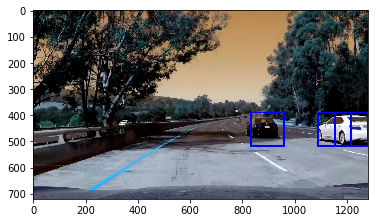

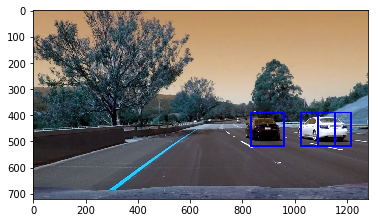

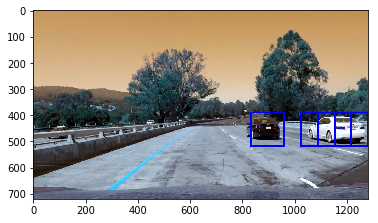

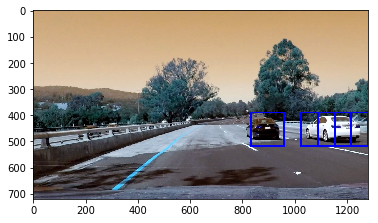

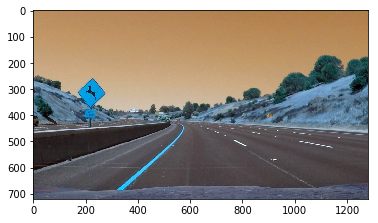

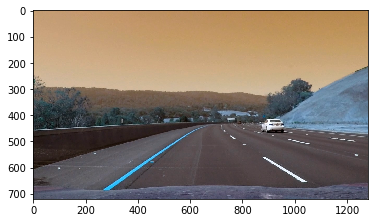

In [82]:
#Run classifier on test images

y_start_stop = [390, 710]

test_images = glob.glob('test_images/test*.jpg')

if DBG == True:
    print(test_images)

for img_src in test_images:
    img = cv2.imread(img_src)
    
    window_list = get_sliding_window_boxes(img,
                   y_start_stop=y_start_stop,
                   xy_window_size=(128, 128),
                   xy_overlap_size=(0.5, 0.5))
    
    hot_windows = search_windows_and_classify(img,
                                window_list,
                                classifier=svc,
                                scaler=X_scaler,
                                cspace=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, hist_range=hist_range,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    print('Number of cars found for image:', img_src)
    print(len(hot_windows))
    
    windowed_img = draw_boxes(img, hot_windows)
    
    plt.figure()
    plt.imshow(windowed_img)
    

In [ ]:


    


test_images_path = 'test_images/'
test_images = glob.glob('test_images/test*.jpg')

test_img = cv2.imread('test_images/test1.jpg')



















import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread('test_images/test1.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()












    
    





colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 14
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"





import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')








windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       

